# OCG598 Project 1
## Abby Baskind
### Problem Description
$$
\frac{\partial f}{\partial t} + c \frac{\partial f}{\partial x} = k \frac{\partial^2 f}{\partial x^2} - \lambda f
$$

#### Scheme 1
$$ 
{f_j^{n+1}} = {f_j^{n}} (1 + \frac{c\Delta t}{\Delta x} - \frac{2\kappa \Delta t}{(\Delta x)^2} - \lambda \Delta t) + {f_{j+1}^{n}} (\frac{\kappa \Delta t}{(\Delta x)^2} - \frac{c\Delta t}{\Delta x}) + {f_{j+1}^{n}} \frac{\kappa \Delta t}{(\Delta x)^2}
$$

#### Scheme 2

$$
{f_j^{n+1}} = {f_j^{n}} (1 - \frac{c\Delta t}{\Delta x} - \frac{2\kappa \Delta t}{(\Delta x)^2} - \lambda \Delta t) + {f_{j+1}^{n}} \frac{\kappa \Delta t}{(\Delta x)^2} + {f_{j-1}^{n}} (\frac{\kappa \Delta t}{(\Delta x)^2} + \frac{c\Delta t}{\Delta x})
$$

#### Scheme 3

$$
{f_j^{n+1}} = {f_j^{n}} (1 - \frac{2\kappa \Delta t}{(\Delta x)^2} - \lambda \Delta t) + {f_{j+1}^{n}} (\frac{\kappa \Delta t}{(\Delta x)^2} - \frac{c\Delta t}{2\Delta x}) + {f_{j-1}^{n}} (\frac{\kappa \Delta t}{(\Delta x)^2} + \frac{c\Delta t}{2\Delta x})
$$

#### Boundary

$$
f(x = 0, t = t_{all}) = f(t) = \frac{t}{\tau e^{\frac{-t^2}{\tau^2}}} \\
f(x = x_{all}, t = 0) = 0 \\
f(x = L, t = t_{all}) = 0
$$


In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.animation as animation

In [45]:
dt = 10000
dx = 1500
(0.01/2)*(0.01*dt -dx)

-7.0

In [9]:
# define variables
L = 10**6
c = 0.01
k = 10**2
h = 1.8e-9
TAU = 15.768e6

# define grids
dt = 10000
dx = 10000 # if x is in meters, 100,000 is about one degree latitude
x = np.arange(0,L+dx,dx) # (start, stop, interval)
N = 10000
T = np.arange(0,N*dt,dt) # (start, stop, interval)
f = np.empty((len(T),len(x)))

for n in range(0,len(T)-1):
    
    # Left Boundary
    f[n,0] = T[n]/(TAU) * np.exp(-T[n]**2/TAU**2)
    
    # Right Boundary
    f[n,-1] = 0
    
    for j in range(0,len(x)-1):
        
        f[0,j] = 0
        f[n+1,j] = f[n,j] * (1 - 2 * (k*dt)/(dx*dx) - h*dt - (c*dt)/dx) + f[n,j+1] * (k*dt)/(dx*dx) + f[n,j-1] * ((k*dt)/(dx*dx) + (c*dt)/dx)
        # f[n+1,j] = (k*dt)/(dx*dx) * (f[n,j+1] - 2*f[n,j] + f[n,j-1]) - h*dt * f[n,j] - (c*dt)/dx * (f[n,j] - f[n,j-1]) + f[n,j]

Text(0.5, 0.98, 'Explicit Differentation')

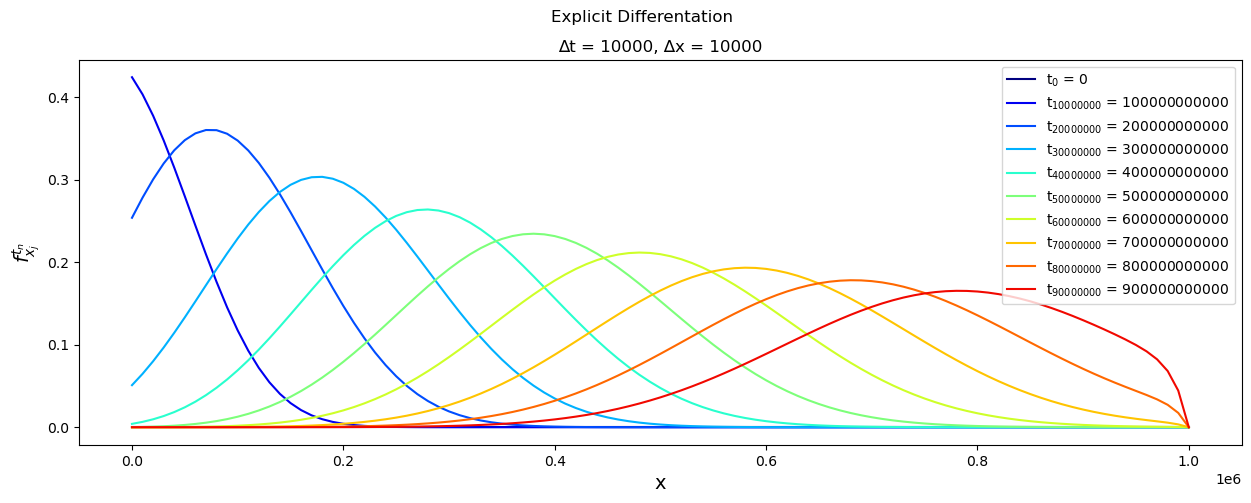

In [10]:
fig, ax = plt.subplots(figsize = [15,5])

INDEXES = []
nvals = T[::1000].flatten()
for M,V in enumerate(nvals):
    INDEX = list(T.flatten()).index(V)
    INDEXES.append(INDEX)

colors = plt.cm.jet(np.linspace(0,dt,T.max()))

for ni, nval in enumerate(nvals):
    NI = INDEXES[ni]
    # lbl = 'n = ' + str(nval) + ', t = ' + str(round(delT * nval,6))
    lbl = r't$_{' + str(nval) + '}$ = ' + str(round(dt * nval,6))
    ax.plot(x, f[NI,:], label = lbl, c = colors[NI])
ax.legend()
ax.set_title('∆t = ' + str(dt) + ', ∆x = ' + str(dx))
ax.set_ylabel(r'$f_{x_j}^{t_n}$', fontsize = 14)
ax.set_xlabel('x', fontsize = 14)
    
fig.suptitle('Explicit Differentation')

In [14]:
nvals * dt

array([           0, 100000000000, 200000000000, 300000000000,
       400000000000, 500000000000, 600000000000, 700000000000,
       800000000000, 900000000000])

In [13]:
INDEXES

[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]

In [15]:
f[9000,:].max()

0.1653049173585255

In [16]:
# define variables
L = 10**6
c = 0.01
k = 10**2
h = 1.8e-9
TAU = 15.768e6

# define grids
dt = 1000
dx = 10000 # if x is in meters, 100,000 is about one degree latitude
x = np.arange(0,L+dx,dx) # (start, stop, interval)
N = 100000
T = np.arange(0,N*dt,dt) # (start, stop, interval)
f = np.empty((len(T),len(x)))

for n in range(0,len(T)-1):
    
    # Left Boundary
    f[n,0] = T[n]/(TAU) * np.exp(-T[n]**2/TAU**2)
    
    # Right Boundary
    f[n,-1] = 0
    
    for j in range(0,len(x)-1):
        
        f[0,j] = 0
        f[n+1,j] = f[n,j] * (1 - 2 * (k*dt)/(dx*dx) - h*dt - (c*dt)/dx) + f[n,j+1] * (k*dt)/(dx*dx) + f[n,j-1] * ((k*dt)/(dx*dx) + (c*dt)/dx)
        # f[n+1,j] = (k*dt)/(dx*dx) * (f[n,j+1] - 2*f[n,j] + f[n,j-1]) - h*dt * f[n,j] - (c*dt)/dx * (f[n,j] - f[n,j-1]) + f[n,j]

Text(0.5, 0.98, 'Explicit Differentation')

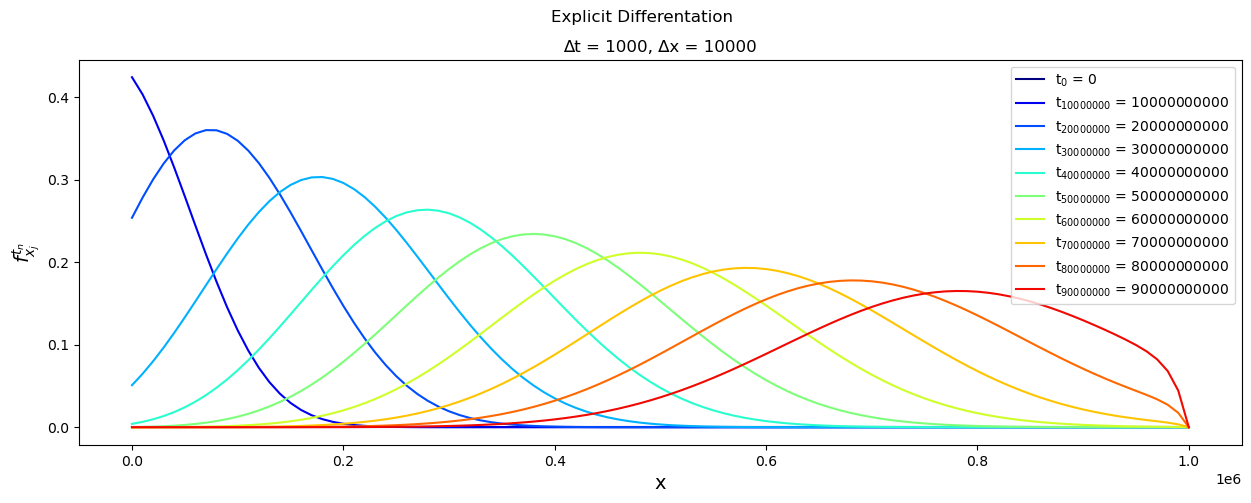

In [17]:
fig, ax = plt.subplots(figsize = [15,5])

INDEXES = []
nvals = T[::10000].flatten()
for M,V in enumerate(nvals):
    INDEX = list(T.flatten()).index(V)
    INDEXES.append(INDEX)

colors = plt.cm.jet(np.linspace(0,dt,T.max()))

for ni, nval in enumerate(nvals):
    NI = INDEXES[ni]
    # lbl = 'n = ' + str(nval) + ', t = ' + str(round(delT * nval,6))
    lbl = r't$_{' + str(nval) + '}$ = ' + str(round(dt * nval,6))
    ax.plot(x, f[NI,:], label = lbl, c = colors[NI])
ax.legend()
ax.set_title('∆t = ' + str(dt) + ', ∆x = ' + str(dx))
ax.set_ylabel(r'$f_{x_j}^{t_n}$', fontsize = 14)
ax.set_xlabel('x', fontsize = 14)
    
fig.suptitle('Explicit Differentation')

In [20]:
nvals

array([       0, 10000000, 20000000, 30000000, 40000000, 50000000,
       60000000, 70000000, 80000000, 90000000])

In [19]:
f[NI,:].max()

0.1650998536159368

In [21]:
# define variables
L = 10**6
c = 0.01
k = 10**2
h = 1.8e-9
TAU = 15.768e6

# define grids
dt = 10000
dx = 20000 # if x is in meters, 100,000 is about one degree latitude
x = np.arange(0,L+dx,dx) # (start, stop, interval)
N = 10000
T = np.arange(0,N*dt,dt) # (start, stop, interval)
f = np.empty((len(T),len(x)))

for n in range(0,len(T)-1):
    
    # Left Boundary
    f[n,0] = T[n]/(TAU) * np.exp(-T[n]**2/TAU**2)
    
    # Right Boundary
    f[n,-1] = 0
    
    for j in range(0,len(x)-1):
        
        f[0,j] = 0
        f[n+1,j] = f[n,j] * (1 - 2 * (k*dt)/(dx*dx) - h*dt - (c*dt)/dx) + f[n,j+1] * (k*dt)/(dx*dx) + f[n,j-1] * ((k*dt)/(dx*dx) + (c*dt)/dx)
        # f[n+1,j] = (k*dt)/(dx*dx) * (f[n,j+1] - 2*f[n,j] + f[n,j-1]) - h*dt * f[n,j] - (c*dt)/dx * (f[n,j] - f[n,j-1]) + f[n,j]

Text(0.5, 0.98, 'Explicit Differentation')

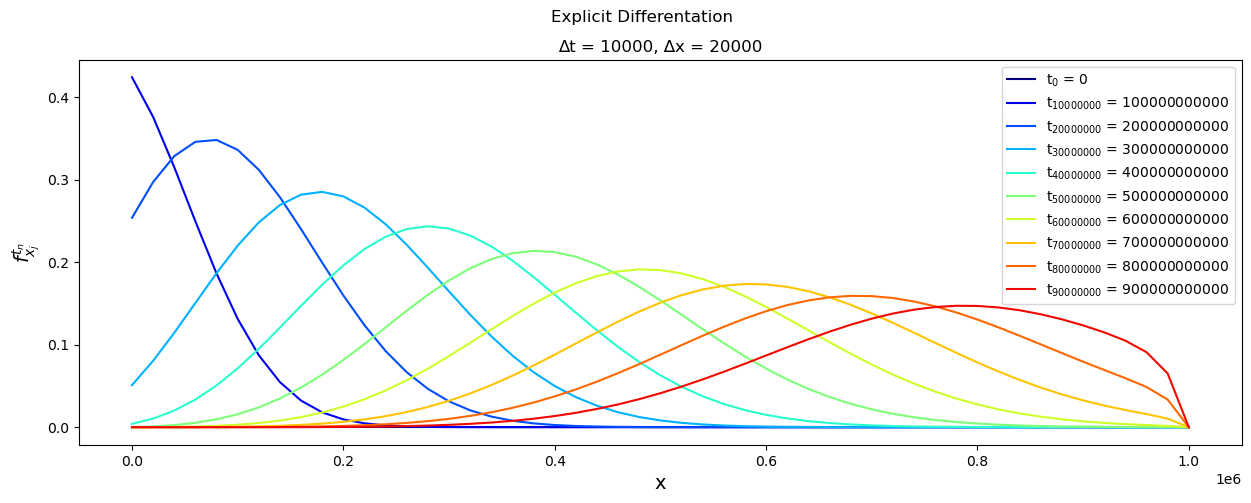

In [22]:
fig, ax = plt.subplots(figsize = [15,5])

INDEXES = []
nvals = T[::1000].flatten()
for M,V in enumerate(nvals):
    INDEX = list(T.flatten()).index(V)
    INDEXES.append(INDEX)

colors = plt.cm.jet(np.linspace(0,dt,T.max()))

for ni, nval in enumerate(nvals):
    NI = INDEXES[ni]
    # lbl = 'n = ' + str(nval) + ', t = ' + str(round(delT * nval,6))
    lbl = r't$_{' + str(nval) + '}$ = ' + str(round(dt * nval,6))
    ax.plot(x, f[NI,:], label = lbl, c = colors[NI])
ax.legend()
ax.set_title('∆t = ' + str(dt) + ', ∆x = ' + str(dx))
ax.set_ylabel(r'$f_{x_j}^{t_n}$', fontsize = 14)
ax.set_xlabel('x', fontsize = 14)
    
fig.suptitle('Explicit Differentation')

In [23]:
f[NI,:].max()

0.14716083126453444

In [24]:
# define variables
L = 10**6
c = 0.01
k = 10**2
h = 1.8e-9
TAU = 15.768e6

# define grids
dt = 10000
dx = 5000 # if x is in meters, 100,000 is about one degree latitude
x = np.arange(0,L+dx,dx) # (start, stop, interval)
N = 10000
T = np.arange(0,N*dt,dt) # (start, stop, interval)
f = np.empty((len(T),len(x)))

for n in range(0,len(T)-1):
    
    # Left Boundary
    f[n,0] = T[n]/(TAU) * np.exp(-T[n]**2/TAU**2)
    
    # Right Boundary
    f[n,-1] = 0
    
    for j in range(0,len(x)-1):
        
        f[0,j] = 0
        f[n+1,j] = f[n,j] * (1 - 2 * (k*dt)/(dx*dx) - h*dt - (c*dt)/dx) + f[n,j+1] * (k*dt)/(dx*dx) + f[n,j-1] * ((k*dt)/(dx*dx) + (c*dt)/dx)
        # f[n+1,j] = (k*dt)/(dx*dx) * (f[n,j+1] - 2*f[n,j] + f[n,j-1]) - h*dt * f[n,j] - (c*dt)/dx * (f[n,j] - f[n,j-1]) + f[n,j]

Text(0.5, 0.98, 'Explicit Differentation')

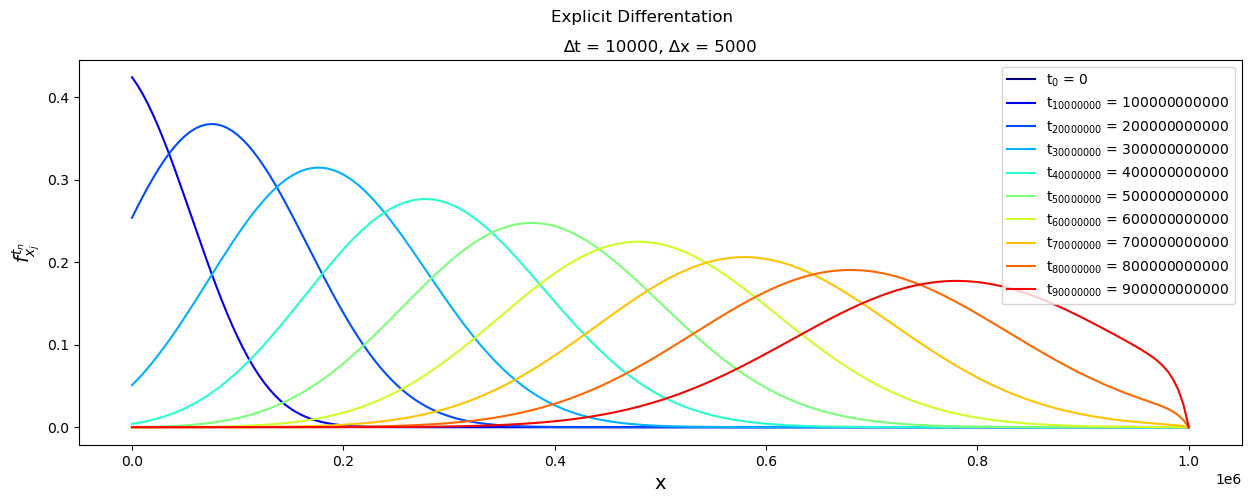

In [25]:
fig, ax = plt.subplots(figsize = [15,5])

INDEXES = []
nvals = T[::1000].flatten()
for M,V in enumerate(nvals):
    INDEX = list(T.flatten()).index(V)
    INDEXES.append(INDEX)

colors = plt.cm.jet(np.linspace(0,dt,T.max()))

for ni, nval in enumerate(nvals):
    NI = INDEXES[ni]
    # lbl = 'n = ' + str(nval) + ', t = ' + str(round(delT * nval,6))
    lbl = r't$_{' + str(nval) + '}$ = ' + str(round(dt * nval,6))
    ax.plot(x, f[NI,:], label = lbl, c = colors[NI])
ax.legend()
ax.set_title('∆t = ' + str(dt) + ', ∆x = ' + str(dx))
ax.set_ylabel(r'$f_{x_j}^{t_n}$', fontsize = 14)
ax.set_xlabel('x', fontsize = 14)
    
fig.suptitle('Explicit Differentation')

In [26]:
f[NI,:].max()

0.17731515565820438

In [42]:
# define variables
L = 10**6
c = 0.01
k = 10**2
h = 1.8e-9
TAU = 15.768e6

# define grids
dt = 10000
dx = 1500 # if x is in meters, 100,000 is about one degree latitude
x = np.arange(0,L+dx,dx) # (start, stop, interval)
N = 10000
T = np.arange(0,N*dt,dt) # (start, stop, interval)
f = np.empty((len(T),len(x)))

for n in range(0,len(T)-1):
    
    # Left Boundary
    f[n,0] = T[n]/(TAU) * np.exp(-T[n]**2/TAU**2)
    
    # Right Boundary
    f[n,-1] = 0
    
    for j in range(0,len(x)-1):
        
        f[0,j] = 0
        f[n+1,j] = f[n,j] * (1 - 2 * (k*dt)/(dx*dx) - h*dt - (c*dt)/dx) + f[n,j+1] * (k*dt)/(dx*dx) + f[n,j-1] * ((k*dt)/(dx*dx) + (c*dt)/dx)
        # f[n+1,j] = (k*dt)/(dx*dx) * (f[n,j+1] - 2*f[n,j] + f[n,j-1]) - h*dt * f[n,j] - (c*dt)/dx * (f[n,j] - f[n,j-1]) + f[n,j]

Text(0.5, 0.98, 'Explicit Differentation')

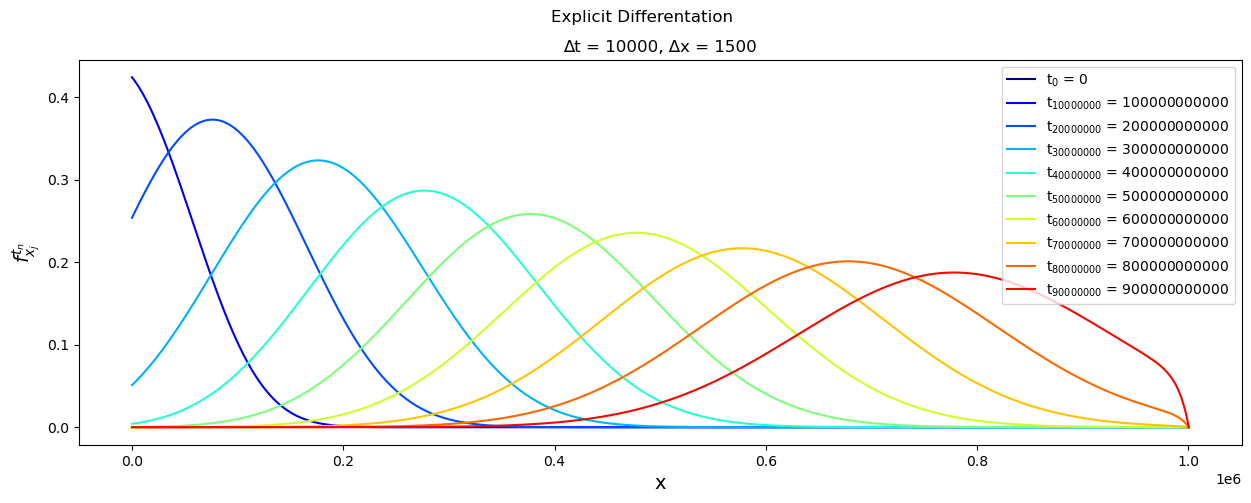

In [43]:
fig, ax = plt.subplots(figsize = [15,5])

INDEXES = []
nvals = T[::1000].flatten()
for M,V in enumerate(nvals):
    INDEX = list(T.flatten()).index(V)
    INDEXES.append(INDEX)

colors = plt.cm.jet(np.linspace(0,dt,T.max()))

for ni, nval in enumerate(nvals):
    NI = INDEXES[ni]
    # lbl = 'n = ' + str(nval) + ', t = ' + str(round(delT * nval,6))
    lbl = r't$_{' + str(nval) + '}$ = ' + str(round(dt * nval,6))
    ax.plot(x, f[NI,:], label = lbl, c = colors[NI])
ax.legend()
ax.set_title('∆t = ' + str(dt) + ', ∆x = ' + str(dx))
ax.set_ylabel(r'$f_{x_j}^{t_n}$', fontsize = 14)
ax.set_xlabel('x', fontsize = 14)
    
fig.suptitle('Explicit Differentation')

In [44]:
f[NI,:].max()

0.18749560801010812